# Check isotopes and adduct correlation in Yeast2021 data

SL 2024-04-24

In [4]:
!pip install --upgrade -q asari-metabolomics

In [12]:
from asari.tools import match_features as mf
from jms.search import *
from mass2chem.search import  *

In [7]:
def list_data(LL):
    new = []
    for x in LL:
        if 'NA' in x or 'na' in x or 'nan' in x:
            new.append(0)
        else:
            new.append(float(x))
    return new

def get_featureList(infile, start_row=1, mz_col=0, rt_col=1, data_col=[11, 12, 13], sep='\t'):
    '''Read features from infile and return a list of json peaks.
    '''
    FL = []
    ii = 0
    for line in open(infile).read().splitlines()[start_row:]:
        ii += 1
        a = line.split(sep)
        data_ = []
        if data_col:
            data_ = list_data([a[ii] for ii in data_col])
        FL.append(
            {'id': 'row'+str(ii+start_row), 'mz': float(a[mz_col]), 'rtime': float(a[rt_col]),
            'data': data_}
        )
    return FL

In [9]:
# get feature lists from diff tools
# use seconds for retention time

true_ = get_featureList('manual_certified.txt', start_row=1, mz_col=1, rt_col=2, data_col=[], sep='\t')
print(len(true_), '\n', true_[3])
for x in true_:
    x['rtime'] = x['rtime']*60

asari_ = get_featureList('asari1.10.6_default_full_Feature_table.tsv', 
                            start_row=1, mz_col=1, rt_col=2, data_col=[11, 12, 13], sep='\t')
print(len(asari_), '\n', asari_[3])

xcms_ = get_featureList('YeastNeg2021_NetID_XCMS_featureTable.csv', 
                           start_row=1, mz_col=1, rt_col=4, data_col=[8, 9, 10], sep=',')
print(len(xcms_), '\n', xcms_[3])

mzmine_ = get_featureList('yeast2021_MZmine2.53_wavelets_featureTable.csv', 
                             start_row=1, mz_col=1, rt_col=2, data_col=[6, 8, 10], sep=',')
print(len(mzmine_), '\n', mzmine_[3])
for x in mzmine_:
    x['rtime'] = x['rtime']*60 
    
mzmine_L_ = get_featureList('yeast2021_MZmine2.53_localminium_featureTable.csv', 
                               start_row=1, mz_col=1, rt_col=2, data_col=[6, 8, 10], sep=',')
print(len(mzmine_L_), '\n', mzmine_L_[3])
for x in mzmine_L_:
    x['rtime'] = x['rtime']*60
    
msdial_ = get_featureList('yeast2021-Area_0_20231191747.txt', 
                             start_row=6, mz_col=2, rt_col=1, data_col=[32, 33, 34], sep='\t')
print(len(msdial_), msdial_[3])
for x in msdial_:
    x['rtime'] = x['rtime']*60

314 
 {'id': 'row5', 'mz': 88.04032, 'rtime': 13.01224, 'data': []}
5341 
 {'id': 'row5', 'mz': 108.0217, 'rtime': 175.23, 'data': [1824783.0, 3119555.0, 1398007.0]}
6043 
 {'id': 'row5', 'mz': 71.0114441447573, 'rtime': 191.529067993164, 'data': [1969533.09827983, 1927442.26717391, 1824055.61486307]}
11290 
 {'id': 'row5', 'mz': 71.05022430419922, 'rtime': 10.932333333333334, 'data': [18001.886980468356, 0.0, 0.0]}
18153 
 {'id': 'row5', 'mz': 71.01144409179688, 'rtime': 3.1790000000000003, 'data': [1612233.9837121586, 0.0, 0.0]}
4166 {'id': 'row10', 'mz': 71.01381, 'rtime': 4.709, 'data': [5303824.0, 5207065.0, 5565071.0]}


In [11]:
d_ = mf.best_rt_match_lcms_features(true_, asari_, mz_ppm=5, rt_tolerance=6)
list(d_.items())[6:8]

Of 314 list1 features, number of uni-direction matched features is 310.


[('row8', 'row3732'), ('row9', 'row953')]

In [17]:
def get_additional_ion(baseions, featurelist, mass_difference=1.003355, mz_tolerance_ppm=5, rt_tolerance=2):
    '''
    Get an isotope or adduct by mass_difference and rt_tolerance, best RT chosen if multiple matches. 
    Returns matched pairs as a list, and intensity data lists as a tuple.
    '''
    query_peaks, other_peaks = [], []
    for p in featurelist:
        if p['id'] in baseions:
            query_peaks.append(p)
        else:
            other_peaks.append(p)
    mztree = build_centurion_tree(other_peaks)
    matched = []
    for p in query_peaks:
        mz_matched = find_all_matches_centurion_indexed_list(p['mz'] + mass_difference, mztree, mz_tolerance_ppm)
        tmp = []
        for p2 in mz_matched:
            delta_rt = abs(p['rtime'] - p2['rtime'])
            if delta_rt < rt_tolerance:
                tmp.append( (delta_rt, p2) )
        if tmp:
            matched.append(
                (p, sorted(tmp)[0][1])
            )
    data1, data2 = [], []
    for pair in matched:
        data1 += pair[0]['data']
        data2 += pair[1]['data']
    return matched, (data1, data2)
    

In [18]:
matched, data = get_additional_ion(
    list(d_.values()), asari_, mass_difference=1.003355, mz_tolerance_ppm=5, rt_tolerance=2
)

In [19]:
print(len(matched), matched[5], data[0][:8])

199 ({'id': 'row272', 'mz': 87.0087, 'rtime': 251.57, 'data': [308863301.0, 368854944.0, 353588028.0]}, {'id': 'row347', 'mz': 88.0121, 'rtime': 252.13, 'data': [10059032.0, 12190729.0, 12095390.0]}) [102082763.0, 99180628.0, 98463706.0, 75494978.0, 74696559.0, 75936090.0, 70284056.0, 68795969.0]


In [20]:
sodium_matched, sodium_data = get_additional_ion(
    list(d_.values()), asari_, mass_difference=21.9820, mz_tolerance_ppm=5, rt_tolerance=2
)

In [21]:
print(len(sodium_matched), sodium_matched[5], sodium_data[0][:8])

29 ({'id': 'row862', 'mz': 145.0617, 'rtime': 803.75, 'data': [2207954526.0, 2201177633.0, 2212787019.0]}, {'id': 'row939', 'mz': 167.0436, 'rtime': 804.32, 'data': [11912241.0, 11833142.0, 11637768.0]}) [102082763.0, 99180628.0, 98463706.0, 33145405.0, 33625711.0, 31988538.0, 17349138.0, 17258763.0]


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

In [32]:
def logpair(datatuple):
    d1 = np.log2(np.array(datatuple[0]) + 1)
    d2 = np.log2(np.array(datatuple[1]) + 1)
    new = zip(d1, d2)
    new = [x for x in new if x[0] > 0 and x[1] > 0]
    return [x[0] for x in new], [x[1] for x in new]

In [33]:
d1, d2 = logpair(data)
pearsonr(d1, d2)

(0.7441197638706984, 1.227413217852372e-102)

In [58]:
def plot_pair(C13data, sodium_data, title):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    x,y = logpair(C13data)
    r, p = pearsonr(x, y)
    print("Got %d 13C pairs with R = %.2f." %(len(x), round(r,2)))
    axs[0].scatter(x, y)
    axs[0].set_title( "N = %d, R = %.2f" %(len(x), round(r,2)) )
    axs[0].set_xlabel('Base ions')
    axs[0].set_ylabel("13C ions")
    
    x,y = logpair(sodium_data)
    r, p = pearsonr(x, y)
    print("Got %d Na/H pairs with R = %.2f.\n" %(len(x), round(r,2)))
    axs[1].scatter(x, y)
    axs[1].set_title( "N = %d, R = %.2f" %(len(x), round(r,2)) )
    axs[1].set_xlabel('Base ions')
    axs[1].set_ylabel("Na ions")
    
    fig.suptitle(title)
    plt.savefig(title + "_additional_ion_check" + ".png")
    plt.savefig(title + "_additional_ion_check" + ".pdf")
    

Got 576 13C pairs with R = 0.74.
Got 79 Na/H pairs with R = 0.53.



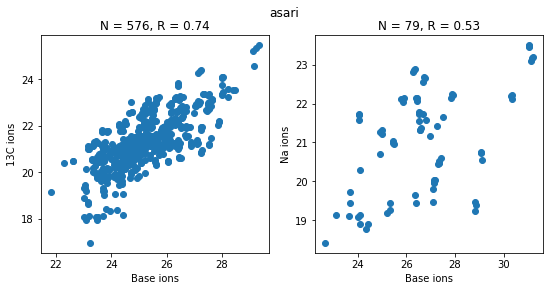

In [59]:
plot_pair(data, sodium_data, "asari")

In [46]:
def match_plot_additional_ions(true_, listx, title):
    d_ = mf.best_rt_match_lcms_features(true_, listx, mz_ppm=5, rt_tolerance=6)

    c13matched, c13data = get_additional_ion(
        list(d_.values()), listx, mass_difference=1.003355, mz_tolerance_ppm=5, rt_tolerance=2
    )
    sodium_matched, sodium_data = get_additional_ion(
        list(d_.values()), listx, mass_difference=21.9820, mz_tolerance_ppm=5, rt_tolerance=2
    )

    plot_pair(c13data, sodium_data, title)

In [56]:
asari_low = get_featureList('asari1.10.6_1e4_full_Feature_table.tsv', 
                            start_row=1, mz_col=1, rt_col=2, data_col=[11, 12, 13], sep='\t')
print(len(asari_), '\n', asari_low[3])

5341 
 {'id': 'row5', 'mz': 70.0298, 'rtime': 178.1, 'data': [46494.0, 47701.0, 59635.0]}


Of 314 list1 features, number of uni-direction matched features is 308.
Got 663 13C pairs with R = 0.70.
Got 207 Na/H pairs with R = 0.51.



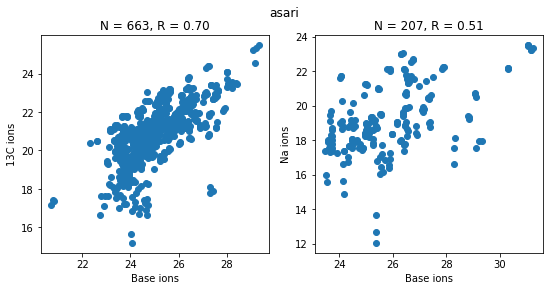

In [64]:
match_plot_additional_ions(true_, asari_low, "asari")

## Do XCMS, MZmine2

Of 314 list1 features, number of uni-direction matched features is 301.
Got 539 13C pairs with R = 0.60.
Got 137 Na/H pairs with R = 0.53.



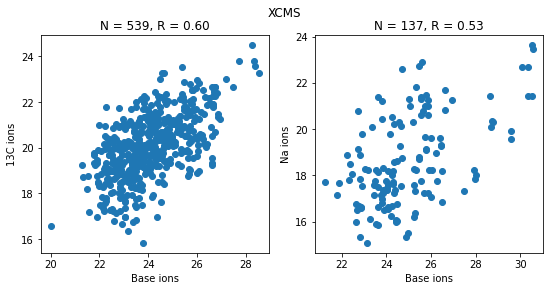

In [61]:
match_plot_additional_ions(true_, xcms_, "XCMS")

Of 314 list1 features, number of uni-direction matched features is 291.
Got 644 13C pairs with R = 0.73.
Got 194 Na/H pairs with R = 0.60.



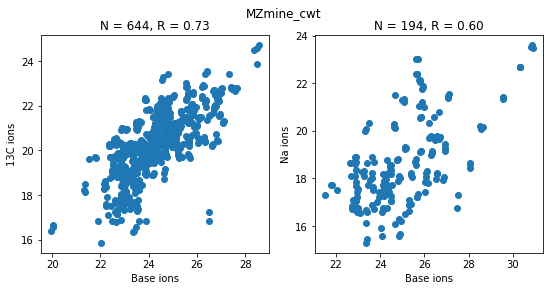

In [62]:
match_plot_additional_ions(true_, mzmine_, "MZmine_cwt")

Of 314 list1 features, number of uni-direction matched features is 271.
Got 493 13C pairs with R = 0.66.
Got 120 Na/H pairs with R = 0.56.



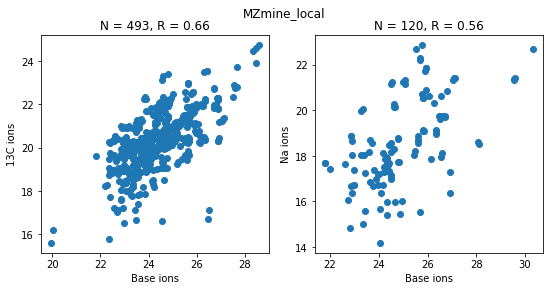

In [63]:
match_plot_additional_ions(true_, mzmine_L_, "MZmine_local")